<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/3-workshops/2019-10-Chicago-DS-users-conference/Chicago-2019-10-Researchers-affiliations-over-time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

# Analyzing Researchers affiliations over time 

What we'll cover in this notebooks

* how to extract researchers data related to an institution 
* how to examine historical affiliations data 
* how to plot these data on a map so to be analysed further

## Installing Dimensions Client Library and Logging In

In [10]:
#
# determine if we are in Colab or Jupyter
try:
  from google.colab import files
  %load_ext google.colab.data_table
  COLAB_ENV = True
  !pip install dimcli plotly_express  -U
except:
  COLAB_ENV = False

#
# load common libraries
import pandas as pd
from pandas.io.json import json_normalize
import time
from tqdm import tqdm_notebook as tqdm
import plotly_express as px
from getpass import getpass
import dimcli
from dimcli.shortcuts import *

#
# set up for exports
if not COLAB_ENV:
  from plotly.offline import init_notebook_mode # needed for exports 
  init_notebook_mode(connected=True)

# log into Dimensions API
##
USERNAME = ""  #@param {type: "string"}

if not USERNAME:
  try: # maybe we are in local, with credentials.ini file
    dimcli.login()
    dsl = dimcli.Dsl() 
  except:
    print("====\nERROR: Please enter a valid Dimensions API username")
else:
  password = getpass('====\nEnter password here')
  print('=> username is', USERNAME)
  print('=> password is', "*" * len(password))
  dimcli.login(USERNAME, password)
  dsl = dimcli.Dsl()


DimCli v0.5.7 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Selecting an organization

Dimensions uses GRID, the [Global Research Identifier Database](https://grid.ac/). So we can use GRID IDs to perform searches across all source in Dimensions. 

Pick one of the institutions listed below to get started. Or just go to the GRID [search page](https://grid.ac/institutes) and find the ID of another institution you are interested in. *NOTE: make sure there is a **hyphen** between the grid ID and the institution name.*

Then hit the 'Play' button to extract the data.


In [11]:
#@title Select an institution

GRID = "grid.16416.34 - University of Rochester" #@param ["grid.16416.34 - University of Rochester", "grid.170205.1 - University of Chicago", "grid.264756.4 - Texas A&M University", "grid.147455.6 - Carnegie Mellon University" ] {allow-input: true}
#@markdown ---

GRIDID = GRID.split("-")[0].strip()
print("You selected: ", GRID)


#
# DATA EXTRACTION
#


print("..extracting data..")
#
# 1. Researchers currently affiliated to this university, by number of publications
#

data1 = dslquery(f"""search researchers where 
                    current_research_org="{GRIDID}" and obsolete=0 
                    return researchers[basics+total_publications] 
                    sort by total_publications limit 1000""")
#
#
#
df1 = data1.as_dataframe()
df1["full_name"] = df1["first_name"] + " " + df1["last_name"]
df1["url"] = "https://app.dimensions.ai/discover/publication?and_facet_researcher=" + df1["id"]


#
# 2. Researchers affiliated to this university at any point in time 
#

data2 = dslquery(f"""search researchers 
                      where research_orgs="{GRIDID}" and obsolete=0 
                      and current_research_org is not empty
                    return researchers[basics+total_publications+current_research_org] 
                    sort by total_publications limit 1000""")
#
#
#
df2 = data2.as_dataframe()
df2["full_name"] = df2["first_name"] + " " + df2["last_name"]
df2 = df2.rename(columns={"current_research_org.name": "name", "current_research_org.country_name": "country"})
df2 = df2.fillna("empty") # fill empty values with a string


#
# 3. 
#
# remove the GRID org we are currenlty focusing on from the data
df3 = df2[df2['current_research_org.id'] != GRIDID]
#
#

print(".. downloading the data as csv ..")
# query1
filename = "researchers_current_{}.csv".format(GRIDID)
df1.to_csv(filename, index=False)
if COLAB_ENV: files.download(filename)
# query2
filename = "researchers_historical_{}.csv".format(GRIDID)
df2.to_csv(filename, index=False)
if COLAB_ENV: files.download(filename)
#
#
print("====\nDone!")

You selected:  grid.16416.34 - University of Rochester
..extracting data..
Returned Researchers: 1000 (total = 8762)
Returned Researchers: 1000 (total = 18035)
.. downloading the data as csv ..
====
Done!


# Data Analysis 

## Researchers currently affiliated to this university, by number of publications

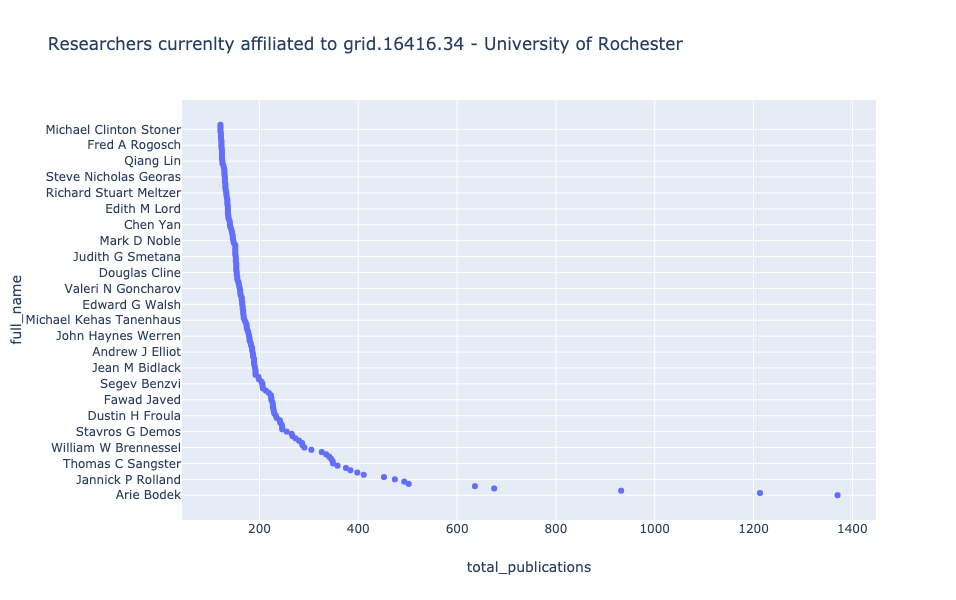

In [12]:
#@title Use the slider to select how many researchers to plot

limit1 = 164  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.scatter(df1[:limit1], x="total_publications", y="full_name", 
           hover_name="full_name", 
           hover_data=['id', 'total_publications'], 
           height=600, title=f"Researchers currenlty affiliated to {GRID}")

## Historical Affiliations VS Current Affiliation: a quick look

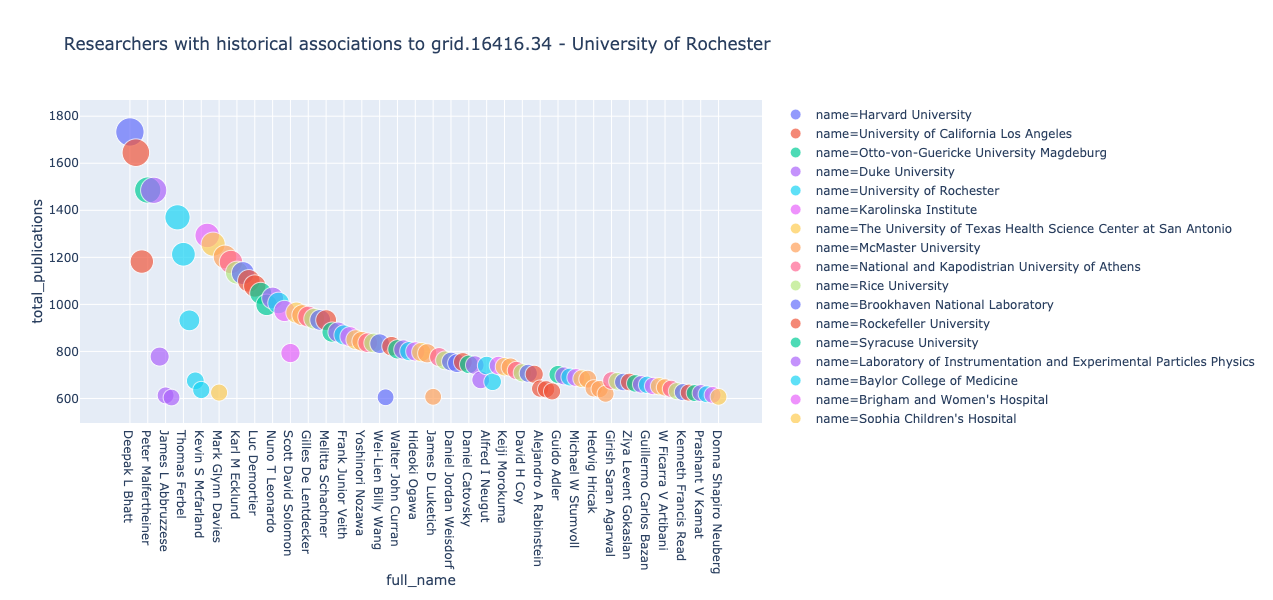

In [13]:
#@title Use the slider to select how many researchers to plot

limit2 = 100  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.scatter(df2[:limit2], x="full_name", y="total_publications", hover_name="full_name", color="name", size="total_publications",
           hover_data=['id', 'total_publications'], 
           height=600, title=f"Researchers with historical associations to {GRID}")

## Distribution of researchers across receiving institutions/countries

By using the `current_research_org` value we can get a quick overview of where the researchers in our dataset are now.



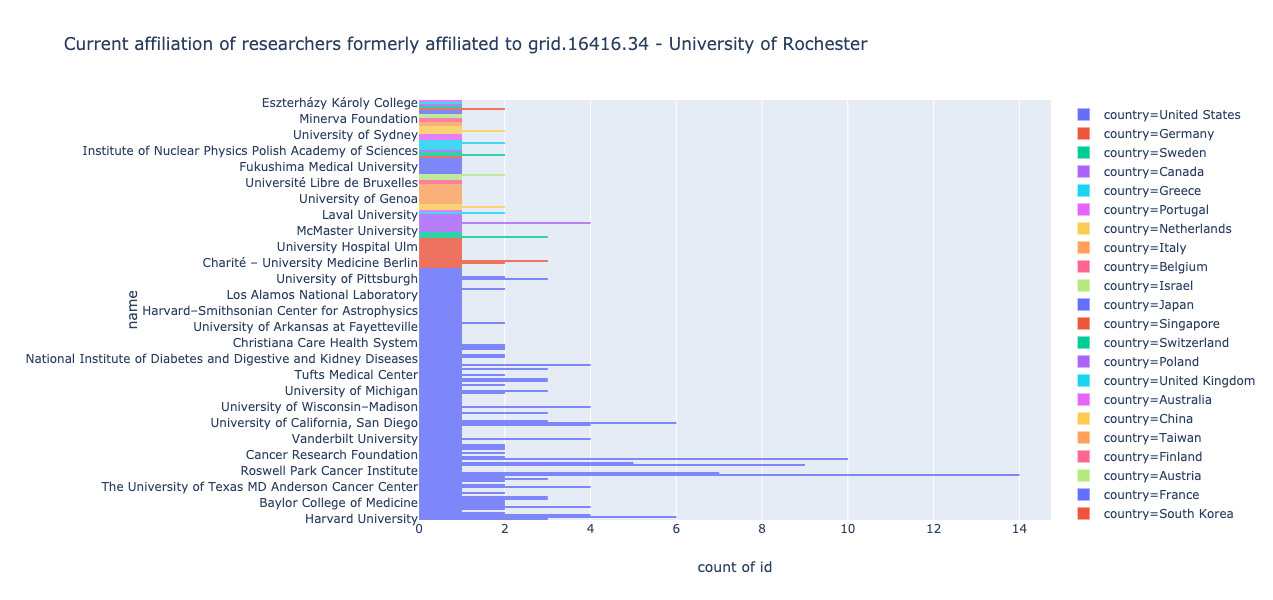

In [14]:
#@title Use the slider to select how many researchers to plot

limit3 = 343  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.histogram(df3[:limit3], x="id", y="name", color="country",
             orientation='h', hover_name="name", 
             hover_data=['current_research_org.id'],
             title=f"Current affiliation of researchers formerly affiliated to {GRID}")

## Distribution of researchers segmented by tot number of high-impact publications 

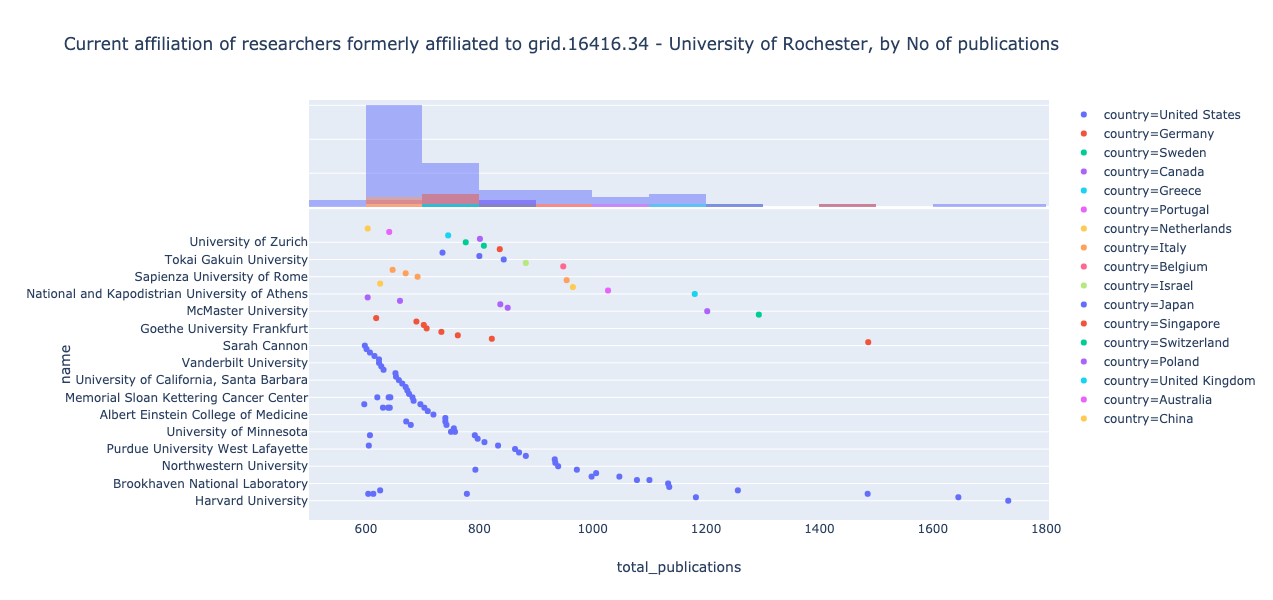

In [15]:
#@title Use the slider to select how many researchers to plot

limit4 = 100  #@param {type: "slider", min: 10, max: 1000}
#@markdown 

px.scatter(df3[:limit4], y="name", x="total_publications",  
           hover_name="full_name", marginal_x="histogram",
           color="country", hover_data=['id', 'total_publications'], 
           height=600, 
           title=f"Current affiliation of researchers formerly affiliated to {GRID}, by No of publications")

---
# Activities

* Try repeating the same analysis for a different organization listed in the [Global Research Identifier Database](https://grid.ac/)
* Try modifying the initial result set eg by adding a keyword search `search publications for "malaria" ...` and see how results change

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 